# Comparing conventional and approximate Multi-Output GPs training time and loss over number of samples

In [2]:
import math
import time
import gc
import logging
from itertools import product
from pathlib import Path

import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

DIRECTORY_PATH = Path("temp/time_complexity")
DATA_FILE_PATH = Path(DIRECTORY_PATH, "multi_time_over_sample_nb.csv")
PLOT_DIR_PATH = Path(DIRECTORY_PATH, "plots")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'}.")

Training on NVIDIA GeForce RTX 3080.


### Define Models
- Gaussian Likelihood
- Zero Mean

In [33]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class ConventionalGPModelLinearCG(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModelLinearCG, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = famgpytorch.kernels.MultitaskKernelLinearCG(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class ApproxGPModel15(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel15, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = famgpytorch.kernels.MultitaskKernelLinearCG(
            famgpytorch.kernels.RBFKernelApprox(number_of_eigenvalues=15), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class ApproxGPModel5(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel5, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = famgpytorch.kernels.MultitaskKernelLinearCG(
            famgpytorch.kernels.RBFKernelApprox(number_of_eigenvalues=5), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

### Set up helper functions used to repeat training and measure time

In [34]:
def train_gp(model_type, nb_training_points):
    train_x = torch.linspace(0, 1, nb_training_points, device=device)
    train_y = torch.stack([
        torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04),
        torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04),
    ], -1)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    likelihood.to(device)
    model = model_type(train_x, train_y, likelihood)
    model.to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    torch.cuda.synchronize()

    try:
        start = time.perf_counter()
        for i in range(50):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
        end = time.perf_counter()
    except (torch.cuda.OutOfMemoryError, RuntimeError) as e:
        logging.error(repr(e)[:140] + "...")
        return None, None, nb_training_points

    return end-start, -mll(model(train_x), train_y).item(), None

def eval_gp(model, likelihood, nb_test_points):
    test_x = torch.linspace(0, 1, nb_test_points, device=device)

    model.eval()
    likelihood.eval()

    start = time.perf_counter()
    with torch.no_grad():
        observed_pred = likelihood(model(test_x))
    end = time.perf_counter()

    return observed_pred, end-start

def repeat_train(model_types, training_sample_nbs, truncate_file=False):
    # create directory for csv file if it does not exist yet
    if not DATA_FILE_PATH.parent.exists():
        DATA_FILE_PATH.parent.mkdir(parents=True)
    if not DATA_FILE_PATH.is_file() or truncate_file:
        # create / truncate file and add headers
        with open(DATA_FILE_PATH, "w", encoding="utf-8") as f:
            f.write(
                "sample_nbs," +
                ",".join([name + "_" + suffix for name, suffix in product(
                    [m.__name__.lower() for m in model_types],
                    ["train_time", "train_nll"]
                )])
            )
        truncate_file = False

    training_times = np.empty(len(model_types), dtype=float)
    training_losses = np.empty(len(model_types), dtype=float)

    failed = set()
    marked = set()

    for train_sample_nb in training_sample_nbs:
        for row, model_type in enumerate(model_types):
            if model_type in failed:
                # skip already failed models
                training_times[row], training_losses[row] = None, None
                continue

            # Make sure everything unnecessary is deleted from memory
            gc.collect()
            torch.cuda.empty_cache()

            if model_type not in marked:
                training_times[row], training_losses[row], failed_sample_nb = train_gp(
                    model_type, nb_training_points=train_sample_nb
                )
                if training_times[row] > 1800:
                    # training took > 1800s -> mark to fail in next iteration
                    marked.add(model_type)
            else:
                training_times[row], training_losses[row], failed_sample_nb = None, None, train_sample_nb

            if failed_sample_nb:
                failed.add(model_type)
                print(f"{model_type.__name__} failed at {failed_sample_nb} data points.")
                if set(model_types).issubset(failed):
                    # break after all models failed
                    break
        else:
            # training did not fail for at least one model, write data
            with open(DATA_FILE_PATH, "a", encoding="utf-8") as f:
                f.write(f"\n{train_sample_nb}," + ",".join([f"{a},{b}" for a, b in zip(training_times, training_losses)]))
            continue

        # training did fail for all models, break out
        break

### Repeat the training for models and plot data

In [23]:
sample_nbs = np.arange(2000, 100001, 2000)
repeat_train([ConventionalGPModel, ConventionalGPModelLinearCG, ApproxGPModel15, ApproxGPModel5], sample_nbs, truncate_file=True)

KeyboardInterrupt: 

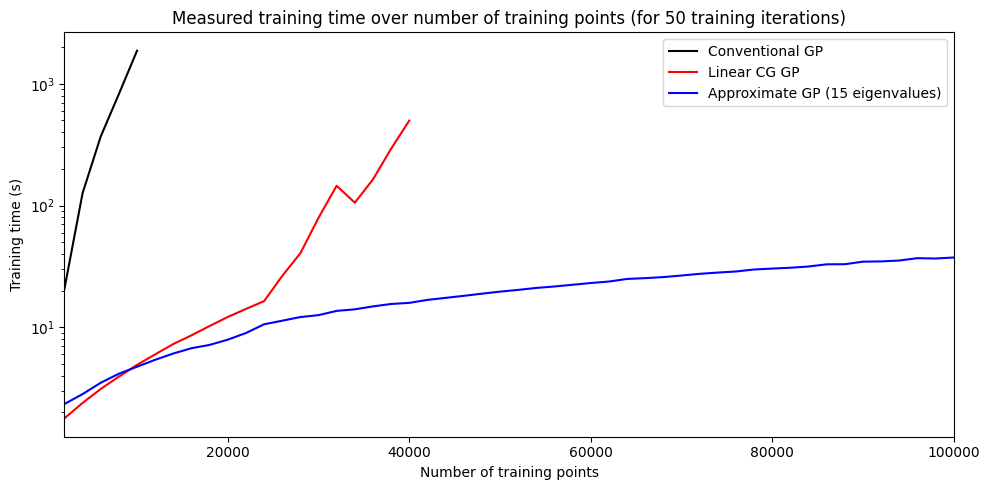

In [14]:
with open(DATA_FILE_PATH, "r", encoding="utf-8") as f:
    line_count = len(f.readlines()) - 1
    f.seek(0)
    headers = f.readline()  # discard headers

    sample_nbs = np.empty(line_count, dtype=int)
    train_t = np.empty((len(headers.split(",")[1:])//2, line_count), dtype=float)
    train_l = np.empty((len(headers.split(",")[1:])//2, line_count), dtype=float)
    col = 0
    while line := f.readline():
        data = line.split(',')
        sample_nbs[col] = data[0]

        for row, v in enumerate(data[1:]):
            if row % 2 == 0:
                train_t[row // 2, col] = v
            else:
                train_l[row // 2, col] = v

        col += 1

# plot results
f, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)

# compute expected runtimes
expected_train_t = np.expand_dims(sample_nbs.astype(float), axis=0).repeat(train_t.shape[0], axis=0)
expected_train_t[0] = sample_nbs ** 3
expected_train_t[0] = expected_train_t[0] * train_t[0,0] / expected_train_t[0,0]

expected_train_t[1] = sample_nbs ** 3
expected_train_t[1] = expected_train_t[1] * train_t[1,0] / expected_train_t[1,0]

expected_train_t[2] = sample_nbs
expected_train_t[2] = expected_train_t[2] * train_t[2,0] / expected_train_t[2,0]

expected_train_t[3] = sample_nbs
expected_train_t[3] = expected_train_t[3] * train_t[3,0] / expected_train_t[3,0]

# plot training time
ax1.set_title("Measured training time over number of training points (for 50 training iterations)")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Training time (s)")

ax1.plot(sample_nbs, train_t[0], 'k')
ax1.plot(sample_nbs, train_t[1], 'r')
ax1.plot(sample_nbs, train_t[2], 'b')
#ax1.plot(sample_nbs, train_t[3], 'g')

ax1.set_yscale('log')

ax1.set_xlim(x_min, x_max)
#ax1.legend(["Conventional GP", "Linear CG GP"])
ax1.legend(["Conventional GP", "Linear CG GP", "Approximate GP (15 eigenvalues)"])

f.tight_layout()
path = Path(PLOT_DIR_PATH, "conv_vs_linear_cg.png")
if not path.parent.exists():
    path.parent.mkdir(parents=True)
plt.savefig(path)

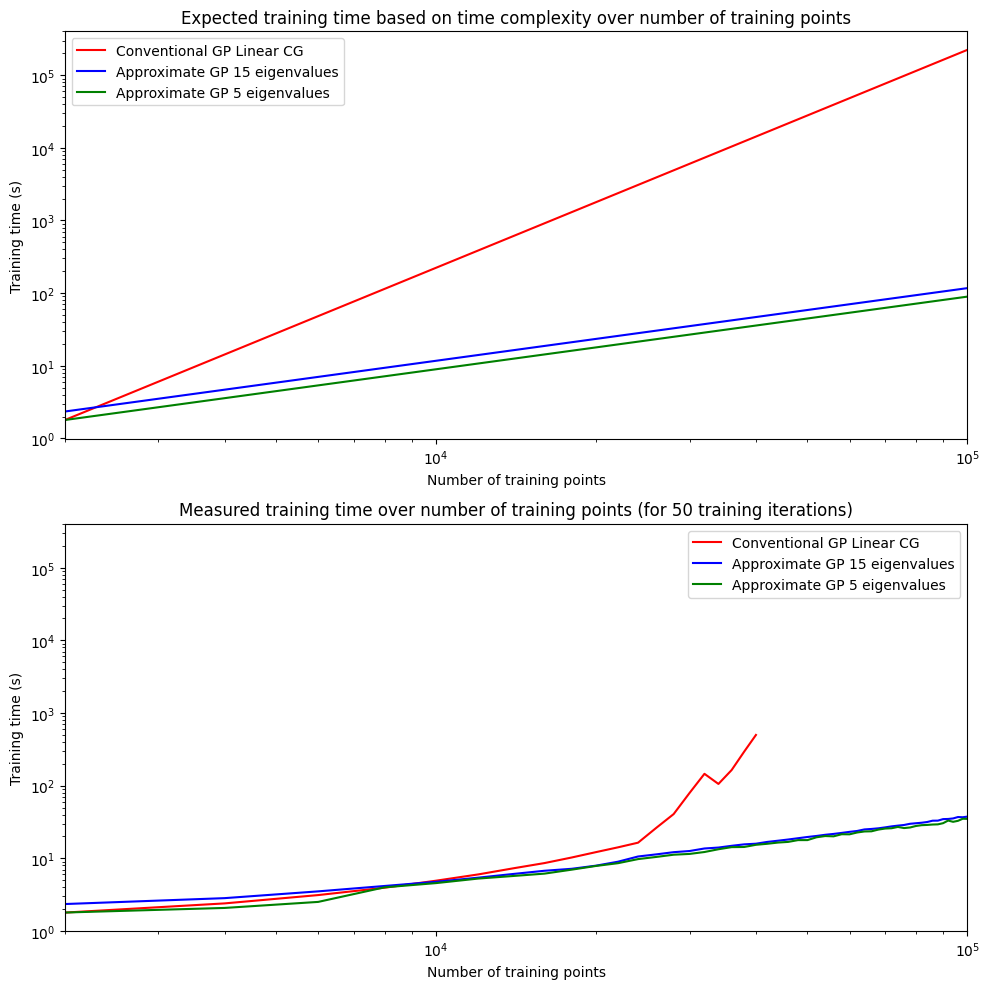

In [6]:
# plot results
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)

ax1.set_title("Expected training time based on time complexity over number of training points")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Training time (s)")

ax1.loglog(sample_nbs, expected_train_t[1], 'r')
ax1.loglog(sample_nbs, expected_train_t[2], 'b')
ax1.loglog(sample_nbs, expected_train_t[3], 'g')

ax1.set_xlim(x_min, x_max)
ax1.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

# plot training time
ax2.set_title("Measured training time over number of training points (for 50 training iterations)")
ax2.set_xlabel("Number of training points")
ax2.set_ylabel("Training time (s)")

ax2.loglog(sample_nbs, train_t[1], 'r')
ax2.loglog(sample_nbs, train_t[2], 'b')
ax2.loglog(sample_nbs, train_t[3], 'g')

ax2.set_xlim(x_min, x_max)
ax2.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

ax1_lims = ax1.get_ylim()
ax2_lims = ax2.get_ylim()
ax1.set_ylim(min(ax1_lims[0], ax2_lims[0]), max(ax1_lims[1], ax2_lims[1]))
ax2.set_ylim(min(ax1_lims[0], ax2_lims[0]), max(ax1_lims[1], ax2_lims[1]))

f.tight_layout()
plt.savefig(Path(PLOT_DIR_PATH, "multi_linear_cg.png"))

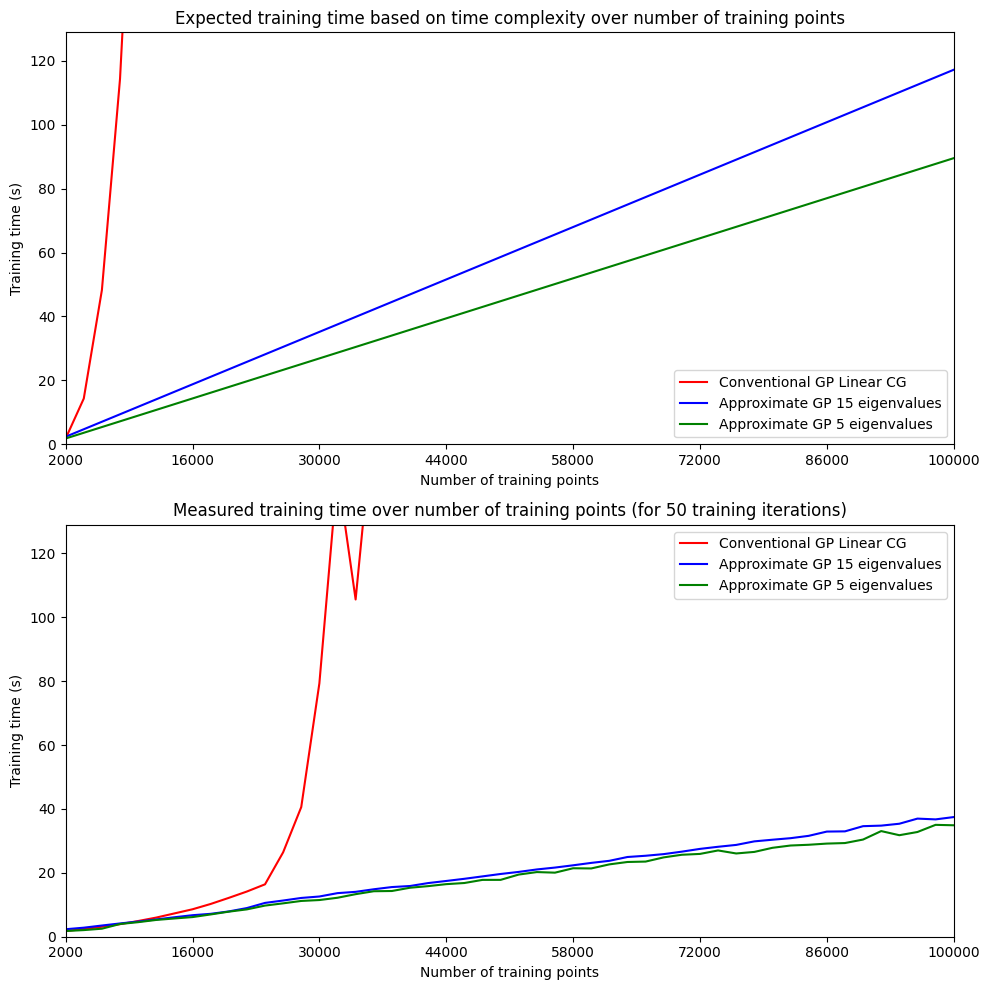

In [37]:
# plot results
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)
y_max = max(np.nanmax(train_t[2:]), np.max(expected_train_t[2:]))

ax1.set_title("Expected training time based on time complexity over number of training points")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Training time (s)")

ax1.plot(sample_nbs, expected_train_t[1], 'r')
ax1.plot(sample_nbs, expected_train_t[2], 'b')
ax1.plot(sample_nbs, expected_train_t[3], 'g')

ax1.set_ylim(0, y_max + y_max / 10)
ax1.set_xlim(x_min, x_max)
ax1.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax1.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

# plot training time
ax2.set_title("Measured training time over number of training points (for 50 training iterations)")
ax2.set_xlabel("Number of training points")
ax2.set_ylabel("Training time (s)")

ax2.plot(sample_nbs, train_t[1], 'r')
ax2.plot(sample_nbs, train_t[2], 'b')
ax2.plot(sample_nbs, train_t[3], 'g')

ax2.set_ylim(0, y_max + y_max / 10)
ax2.set_xlim(x_min, x_max)
ax2.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax2.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

f.tight_layout()
plt.savefig(Path(PLOT_DIR_PATH, "multi_approx.png"))

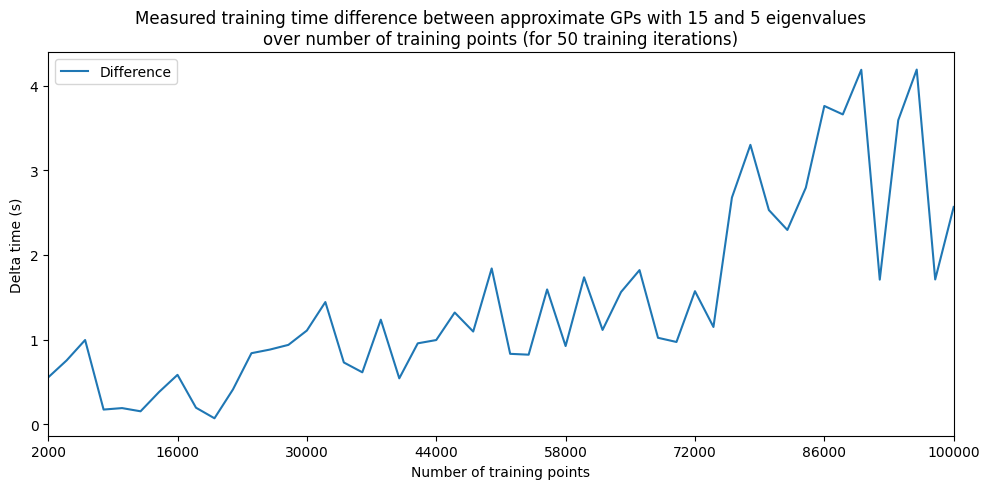

In [38]:
# plot difference between runtime of approx GPs wit 15 and 5 eigenvalues
train_diff = train_t[2] - train_t[3]

f, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)
y_max = np.nanmax(train_diff)

ax1.set_title("Measured training time difference between approximate GPs with 15 and 5 eigenvalues\nover number of training points (for 50 training iterations)")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Delta time (s)")

ax1.plot(sample_nbs, train_diff)

ax1.set_xlim(x_min, x_max)
ax1.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax1.legend(["Difference"])

f.tight_layout()
plt.savefig(Path(PLOT_DIR_PATH, "multi_diff.png"))

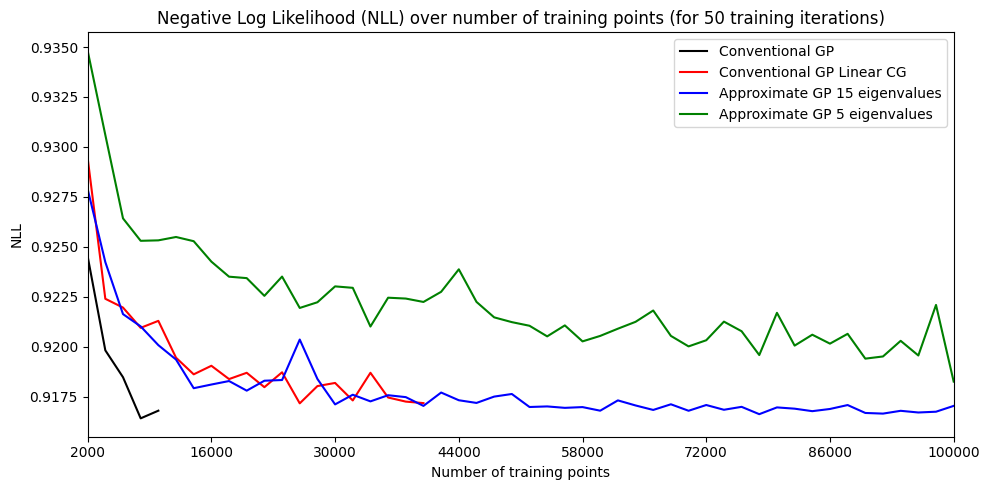

In [39]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)

# plot loss
ax1.set_title("Negative Log Likelihood (NLL) over number of training points (for 50 training iterations)")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("NLL")

ax1.plot(sample_nbs, train_l[0], 'k')
ax1.plot(sample_nbs, train_l[1], 'r')
ax1.plot(sample_nbs, train_l[2], 'b')
ax1.plot(sample_nbs, train_l[3], 'g')

ax1.set_xlim(x_min, x_max)
ax1.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax1.legend(["Conventional GP", "Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

f.tight_layout()
plt.savefig(Path(PLOT_DIR_PATH, "multi_nll.png"))